# XAI Project - Neural Network Interpretation for Banking Regulatory Compliance



## 1. Pre-trained Classification Model Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

The MNIST dataset contains handwritten numbers from 0 to 9.  
To fit DenseNet requirements (the pretrained model) we are resizing to 224x224 and 3 channel.

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"\nTest samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]


Training samples: 60000

Test samples: 10000


In [3]:
model = models.densenet121(pretrained=True)

num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)

print(model.classifier)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 183MB/s]


Linear(in_features=1024, out_features=10, bias=True)


Now we do fine-tuning of the model, freezing feature extraction layers.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, criterion, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')

        print(f'Epoch {epoch+1} completed, Average Loss: {running_loss/len(train_loader):.6f}')

train_model(model, train_loader, optimizer, criterion)

Epoch 1/2, Batch 0, Loss: 2.382773
Epoch 1/2, Batch 100, Loss: 0.846229
Epoch 1/2, Batch 200, Loss: 0.561773
Epoch 1/2, Batch 300, Loss: 0.523277
Epoch 1/2, Batch 400, Loss: 0.330078
Epoch 1/2, Batch 500, Loss: 0.253613
Epoch 1/2, Batch 600, Loss: 0.352120
Epoch 1/2, Batch 700, Loss: 0.243030
Epoch 1/2, Batch 800, Loss: 0.147810
Epoch 1/2, Batch 900, Loss: 0.288777
Epoch 1/2, Batch 1000, Loss: 0.455954
Epoch 1/2, Batch 1100, Loss: 0.310368
Epoch 1/2, Batch 1200, Loss: 0.215709
Epoch 1/2, Batch 1300, Loss: 0.245123
Epoch 1/2, Batch 1400, Loss: 0.347100
Epoch 1/2, Batch 1500, Loss: 0.287443
Epoch 1/2, Batch 1600, Loss: 0.180501
Epoch 1/2, Batch 1700, Loss: 0.298401
Epoch 1/2, Batch 1800, Loss: 0.206653
Epoch 1 completed, Average Loss: 0.371111
Epoch 2/2, Batch 0, Loss: 0.291009
Epoch 2/2, Batch 100, Loss: 0.192705
Epoch 2/2, Batch 200, Loss: 0.107005
Epoch 2/2, Batch 300, Loss: 0.393789
Epoch 2/2, Batch 400, Loss: 0.184900
Epoch 2/2, Batch 500, Loss: 0.361556
Epoch 2/2, Batch 600, Loss: 

In [5]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}% ({correct}/{total})')
    return accuracy

accuracy = evaluate_model(model, test_loader)

Test Accuracy: 95.71% (9571/10000)


## 2. Saliency Map Generation


In [6]:
!pip install captum --no-deps
!pip install typing_extensions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.4 MB/s eta 0:00:00


In [7]:
from captum.attr import (
    IntegratedGradients,
    Saliency,
    GradientShap,
    Occlusion,
    LayerGradCam
)
from captum.attr import visualization as viz
import warnings
warnings.filterwarnings('ignore')

In [8]:
def get_sample_images(test_loader, num_samples=10):
    model.eval()
    samples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)

        for i in range(len(data)):
            if len(samples) >= num_samples:
                return samples

            samples.append({
                'image': data[i],
                'true_label': target[i].item(),
                'predicted_label': pred[i].item(),
                'confidence': torch.softmax(output[i], dim=0).max().item(),
                'correct': target[i].item() == pred[i].item()
            })

    return samples

sample_images = get_sample_images(test_loader, 10)

correct_samples = [s for s in sample_images if s['correct']]
incorrect_samples = [s for s in sample_images if not s['correct']]

print(f"Correct predictions: {len(correct_samples)}")
print(f"Incorrect predictions: {len(incorrect_samples)}")

Correct predictions: 10
Incorrect predictions: 0


### i. Integrated Gradients

In [9]:
def generate_integrated_gradients(model, image, target_class):
    integrated_gradients = IntegratedGradients(model)
    attributions = integrated_gradients.attribute(
        image.unsqueeze(0),
        target=target_class,
        n_steps=50
    )
    return attributions.squeeze()

ig_results = []
for sample in sample_images[:5]:
    ig_attr = generate_integrated_gradients(
        model,
        sample['image'],
        sample['predicted_label']
    )
    ig_results.append({
        'sample': sample,
        'attribution': ig_attr
    })

print("Integrated Gradients computed for 5 samples")

Integrated Gradients computed for 5 samples


### ii. Saliency Maps

In [10]:
def generate_saliency_map(model, image, target_class):
    saliency = Saliency(model)
    attributions = saliency.attribute(
        image.unsqueeze(0),
        target=target_class
    )
    return attributions.squeeze()

saliency_results = []
for sample in sample_images[:5]:
    saliency_attr = generate_saliency_map(
        model,
        sample['image'],
        sample['predicted_label']
    )
    saliency_results.append({
        'sample': sample,
        'attribution': saliency_attr
    })

print("Saliency Maps computed for 5 samples")

Saliency Maps computed for 5 samples


### iii. GradientSHAP

In [11]:
def generate_gradient_shap(model, image, target_class, baseline_dist):
    gradient_shap = GradientShap(model)
    attributions = gradient_shap.attribute(
        image.unsqueeze(0),
        baselines=baseline_dist,
        target=target_class,
        n_samples=50
    )
    return attributions.squeeze()

baseline_dist = torch.randn(10, 3, 224, 224).to(device) * 0.1

shap_results = []
for sample in sample_images[:5]:
    shap_attr = generate_gradient_shap(
        model,
        sample['image'],
        sample['predicted_label'],
        baseline_dist
    )
    shap_results.append({
        'sample': sample,
        'attribution': shap_attr
    })

print("GradientSHAP computed for 5 samples")

GradientSHAP computed for 5 samples


### iv. Occlusion Maps

In [12]:
def generate_occlusion_map(model, image, target_class):
    occlusion = Occlusion(model)
    attributions = occlusion.attribute(
        image.unsqueeze(0),
        target=target_class,
        sliding_window_shapes=(3, 8, 8),
        strides=(3, 4, 4)
    )
    return attributions.squeeze()

occlusion_results = []
for sample in sample_images[:5]:  # First 5 samples
    occlusion_attr = generate_occlusion_map(
        model,
        sample['image'],
        sample['predicted_label']
    )
    occlusion_results.append({
        'sample': sample,
        'attribution': occlusion_attr
    })

print("Occlusion Maps computed for 5 samples")

Occlusion Maps computed for 5 samples


### v. Grad-CAM Implementation

We use a  deeper layer in DenseNet for Grad-CAM.

In [13]:
def generate_grad_cam(model, image, target_class):
    layer_gradcam = LayerGradCam(model, model.features.denseblock4)
    attributions = layer_gradcam.attribute(
        image.unsqueeze(0),
        target=target_class
    )
    return attributions.squeeze()

gradcam_results = []
for sample in sample_images[:5]:
    gradcam_attr = generate_grad_cam(
        model,
        sample['image'],
        sample['predicted_label']
    )
    gradcam_results.append({
        'sample': sample,
        'attribution': gradcam_attr
    })

print("Grad-CAM computed for 5 samples")

Grad-CAM computed for 5 samples


## 3. Analysis and Report



### Saliency Map Analysis: Correct vs Incorrect Predictions

In [14]:
def analyze_attribution_patterns():
    print("=== SALIENCY MAP ANALYSIS ===")

    def calculate_concentration(attribution):
        flat_attr = attribution.flatten()
        sorted_attr = np.sort(np.abs(flat_attr))
        n = len(sorted_attr)
        cumsum = np.cumsum(sorted_attr)
        return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

    correct_concentrations = []
    incorrect_concentrations = []

    for i, result in enumerate(ig_results):
        concentration = calculate_concentration(result['attribution'].cpu().detach().numpy())
        if result['sample']['correct']:
            correct_concentrations.append(concentration)
        else:
            incorrect_concentrations.append(concentration)

    if correct_concentrations:
        print(f"Average attribution concentration (correct): {np.mean(correct_concentrations):.3f}")
    if incorrect_concentrations:
        print(f"Average attribution concentration (incorrect): {np.mean(incorrect_concentrations):.3f}")

    correct_magnitudes = []
    incorrect_magnitudes = []

    for i, result in enumerate(ig_results):
        magnitude = np.mean(np.abs(result['attribution'].cpu().detach().numpy()))
        if result['sample']['correct']:
            correct_magnitudes.append(magnitude)
        else:
            incorrect_magnitudes.append(magnitude)

    if correct_magnitudes:
        print(f"Average attribution magnitude (correct): {np.mean(correct_magnitudes):.6f}")
    if incorrect_magnitudes:
        print(f"Average attribution magnitude (incorrect): {np.mean(incorrect_magnitudes):.6f}")

analyze_attribution_patterns()

=== SALIENCY MAP ANALYSIS ===
Average attribution concentration (correct): 0.576
Average attribution magnitude (correct): 0.344337


### Comparison of XAI Techniques

In [15]:
def compare_xai_techniques():

    print("=== XAI TECHNIQUES COMPARISON ===")

    techniques = {
        'Integrated Gradients': ig_results,
        'Saliency Maps': saliency_results,
        'GradientSHAP': shap_results,
        'Occlusion Maps': occlusion_results
    }

    for technique_name, results in techniques.items():
        print(f"\n{technique_name}:")

        avg_magnitude = np.mean([np.mean(np.abs(r['attribution'].cpu().detach().numpy())) for r in results])
        print(f"  Average magnitude: {avg_magnitude:.6f}")

        all_attrs = np.concatenate([r['attribution'].cpu().detach().numpy().flatten() for r in results])
        sparsity = np.mean(np.abs(all_attrs) < np.std(all_attrs) * 0.1) * 100
        print(f"  Sparsity: {sparsity:.1f}%")

        correlations = []
        for i in range(len(results)-1):
            attr1 = results[i]['attribution'].cpu().detach().numpy().flatten()
            attr2 = results[i+1]['attribution'].cpu().detach().numpy().flatten()
            corr = np.corrcoef(attr1, attr2)[0, 1]
            if not np.isnan(corr):
                correlations.append(abs(corr))

        if correlations:
            print(f"  Average consistency: {np.mean(correlations):.3f}")

compare_xai_techniques()

=== XAI TECHNIQUES COMPARISON ===

Integrated Gradients:
  Average magnitude: 0.344337
  Sparsity: 20.5%
  Average consistency: 0.083

Saliency Maps:
  Average magnitude: 0.697856
  Sparsity: 21.1%
  Average consistency: 0.131

GradientSHAP:
  Average magnitude: 0.141746
  Sparsity: 15.0%
  Average consistency: 0.126

Occlusion Maps:
  Average magnitude: 3.157966
  Sparsity: 4.5%
  Average consistency: 0.215


### Model Error Analysis

The model turns out to be very accurate, so we'll try to find those specific mismatches.

=== MODEL ERROR ANALYSIS ===
Found 10 incorrect predictions
\nConfusion patterns found:
  True: 9, Predicted: 7 (2 times)
  True: 3, Predicted: 2 (2 times)
  True: 7, Predicted: 4 (1 times)
  True: 9, Predicted: 0 (1 times)
  True: 5, Predicted: 3 (1 times)
  True: 3, Predicted: 7 (1 times)
  True: 2, Predicted: 9 (1 times)
  True: 8, Predicted: 9 (1 times)
\nError prediction confidences:
  Average: 0.612
  Range: 0.449 - 0.793
\nGenerating XAI explanations for errors...


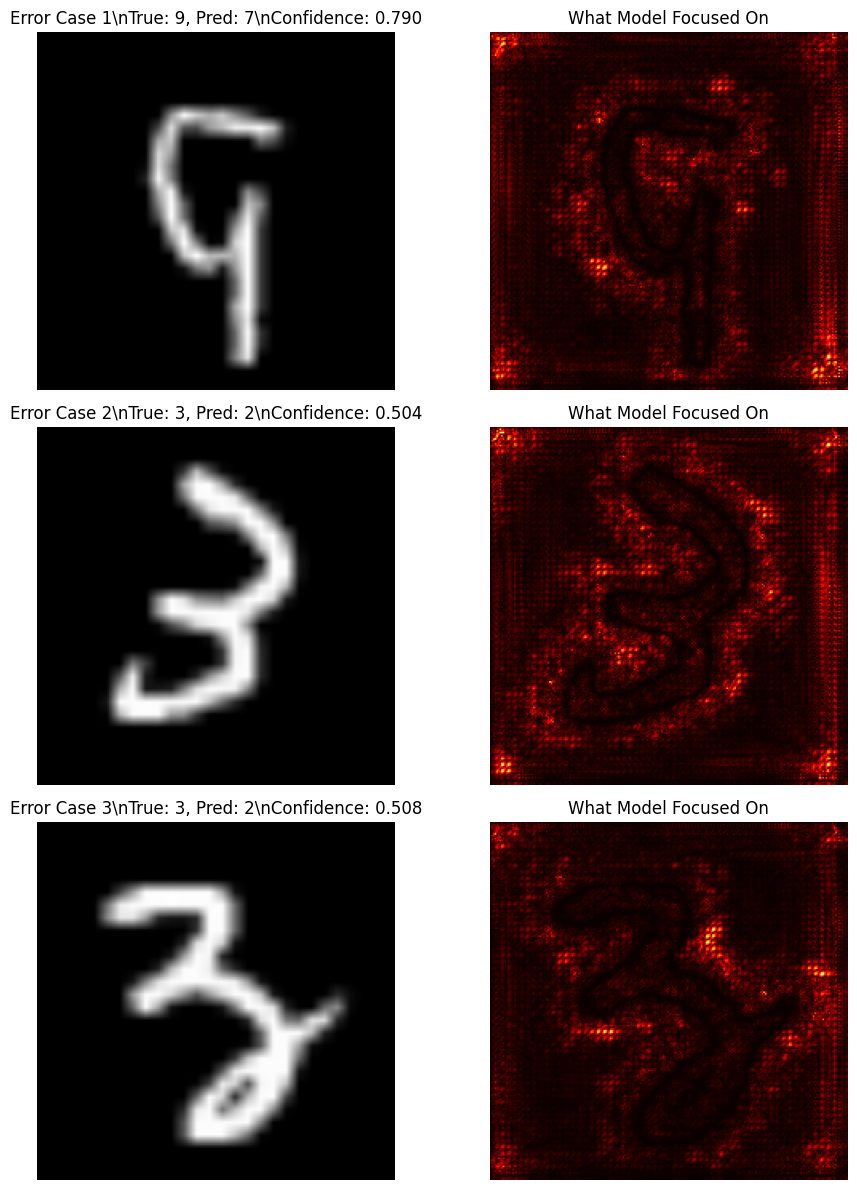

In [16]:
def find_error_samples(test_loader, num_errors=10):
    model.eval()
    error_samples = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            incorrect_mask = pred != target
            incorrect_indices = torch.where(incorrect_mask)[0]

            for idx in incorrect_indices:
                if len(error_samples) >= num_errors:
                    return error_samples

                error_samples.append({
                    'image': data[idx],
                    'true_label': target[idx].item(),
                    'predicted_label': pred[idx].item(),
                    'confidence': torch.softmax(output[idx], dim=0).max().item()
                })

    return error_samples

def analyze_model_errors():

    print("=== MODEL ERROR ANALYSIS ===")

    error_samples = find_error_samples(test_loader, 10)

    if len(error_samples) == 0:
        print("No incorrect predictions found")
        return

    print(f"Found {len(error_samples)} incorrect predictions")

    confusion_pairs = {}
    for sample in error_samples:
        pair = (sample['true_label'], sample['predicted_label'])
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

    print("\\nConfusion patterns found:")
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    for (true, pred), count in sorted_pairs:
        print(f"  True: {true}, Predicted: {pred} ({count} times)")

    confidences = [s['confidence'] for s in error_samples]
    print(f"\\nError prediction confidences:")
    print(f"  Average: {np.mean(confidences):.3f}")
    print(f"  Range: {np.min(confidences):.3f} - {np.max(confidences):.3f}")

    print("\\nGenerating XAI explanations for errors...")
    error_ig_results = []
    for sample in error_samples[:5]:
        ig_attr = generate_integrated_gradients(
            model,
            sample['image'],
            sample['predicted_label']
        )
        error_ig_results.append({
            'sample': sample,
            'attribution': ig_attr
        })

    num_errors_to_show = min(len(error_ig_results), 3)
    fig, axes = plt.subplots(num_errors_to_show, 2, figsize=(10, 4*num_errors_to_show))
    if num_errors_to_show == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_errors_to_show):
        result = error_ig_results[i]
        sample = result['sample']
        attribution = result['attribution']

        original_img = sample['image'].cpu().detach().numpy()
        original_display = np.mean(original_img, axis=0)
        original_display = (original_display * np.array([0.229, 0.224, 0.225]).mean() + np.array([0.485, 0.456, 0.406]).mean())
        axes[i, 0].imshow(original_display, cmap='gray')
        axes[i, 0].set_title(f'Error Case {i+1}\\nTrue: {sample["true_label"]}, Pred: {sample["predicted_label"]}\\nConfidence: {sample["confidence"]:.3f}')
        axes[i, 0].axis('off')

        attr_img = attribution.cpu().detach().numpy()
        attr_display = np.mean(np.abs(attr_img), axis=0)
        axes[i, 1].imshow(attr_display, cmap='hot')
        axes[i, 1].set_title('What Model Focused On')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return error_samples

error_samples = analyze_model_errors()

### 4. Summary and Recommendations

The model has a high accuracy (95.71%).

Occlusion Maps (OM) has the highest average magnitude and the highest consistency (0.215), suggesting it finds the most impactful features and is the most stable in its explanations.

Saliency Maps (SM) has a high magnitude (0.698) and is highly sparse (21.1%). This suggests it's finding significant importance in highly localized features, but its consistency is moderate (0.131).

Integrated Gradients (IG) has the lowest consistency (0.083), which raises concerns about the reliability or stability of its feature importance attributions across different samples or perturbations. It is also one of the most sparse (20.5%).

GradientSHAP (GS) has the lowest average magnitude (0.142) and is the least sparse (5.0%) among the gradient-based methods (IG, SM, GS). This suggests its attributions are relatively small and slightly more spread out compared to SM/IG, though it's moderately consistent (0.126).

The model is relatively confident in its incorrect classifications, which is a significant concern.

We could suggest to apply regularization or data augmentation to address those mismatches (9/7, 3/2) and focus on OM that turned out to be the most robust approach.

06/10/2025 -  Pablo Di Marco